In [1]:
import os
import mne
import numpy as np
import scipy.signal as sp_signal
import matplotlib.pyplot as plt
from ptsa.data.readers import BaseEventReader

%matplotlib notebook

In [2]:
def lcf(S, feat, sfreq, iqr_thresh=3, dilator_width=.1, transition_width=.1):

    dilator_width = int(dilator_width * sfreq)
    transition_width = int(transition_width * sfreq)

    ##########
    #
    # Classification
    #
    ##########

    # Find interquartile range of each component
    p75 = np.percentile(feat, 75, axis=1)
    p25 = np.percentile(feat, 25, axis=1)
    iqr = p75 - p25

    # Tune artifact thresholds for each component according to the IQR and the iqr_thresh parameter
    pos_thresh = p75 + iqr * iqr_thresh
    neg_thresh = p25 - iqr * iqr_thresh

    # Detect artifacts using the IQR threshold, then dilate the detected zones to account for the mixer transition equation
    ctrl_signal = np.zeros(feat.shape, dtype=int)
    dilator = np.ones(dilator_width)
    for i in range(ctrl_signal.shape[0]):
        ctrl_signal[i, :] = (feat[i, :] > pos_thresh[i]) | (feat[i, :] < neg_thresh[i])
        ctrl_signal[i, :] = np.convolve(ctrl_signal[i, :], dilator, 'same')
    del p75, p25, iqr, pos_thresh, neg_thresh, dilator

    # Binarize signal
    ctrl_signal = (ctrl_signal > 0).astype(int)

    ##########
    #
    # Mixing
    #
    ##########

    # Allocate normalized transition window
    trans_win = sp_signal.hann(transition_width, True)
    trans_win /= trans_win.sum()

    # Pad extremes of control signal
    pad_width = [tuple([0, 0])] * ctrl_signal.ndim
    pad_size = int(transition_width / 2 + 1)
    pad_width[1] = (pad_size, pad_size)
    ctrl_signal = np.pad(ctrl_signal, tuple(pad_width), mode='edge')
    del pad_width

    # Combine the transition window and the control signal to build a final transition-control signal, which can be applied to the components
    for i in range(ctrl_signal.shape[0]):
        ctrl_signal[i, :] = np.convolve(ctrl_signal[i, :], trans_win, 'same')
    del trans_win

    # Remove padding from transition-control signal
    rm_pad_slice = [slice(None)] * ctrl_signal.ndim
    rm_pad_slice[1] = slice(pad_size, -pad_size)
    ctrl_signal = ctrl_signal[rm_pad_slice]
    del rm_pad_slice, pad_size

    # Mix sources with control signal to get cleaned sources
    S_clean = S * (1 - ctrl_signal)

    return S_clean

def reconstruct_signal(sources, ica):
    # Mix sources to translate back into PCA components (PCA components x Time)
    data = np.dot(ica.mixing_matrix_, sources)

    # Mix PCA components to translate back into original EEG channels (Channels x Time)
    data = np.dot(np.linalg.inv(ica.pca_components_), data)

    # Invert transformations that MNE performs prior to PCA
    data += ica.pca_mean_[:, None]
    data *= ica.pre_whitener_

    return data

In [3]:
#####
# Events processing
#####

subj = 'LTP329'
sess = 5

# Load presentation events
evfile = '/protocols/ltp/subjects/%s/experiments/ltpFR2/sessions/%s/behavioral/current_processed/task_events.json' % (subj, sess)
evs = BaseEventReader(filename=evfile, eliminate_events_with_no_eeg=True).read()
evs = evs[evs.type == 'WORD']

# Check list of EEG files from the session, and choose to work with the one that has the most events 
eegfiles = np.unique(evs.eegfile)
eegfiles = [f for f in eegfiles if f != '']
evcounts = [np.sum(evs.eegfile == f) for f in eegfiles]
eegfile = eegfiles[np.argmax(evcounts)]
system = 'bio' if eegfile.endswith('bdf') else 'egi'

print('Best EEG file for this session identified as %s' % eegfile)

Best EEG file for this session identified as /protocols/ltp/subjects/LTP329/experiments/ltpFR2/sessions/5/ephys/current_processed/LTP329_20160923_012020.mff


In [4]:
# Load EEG data and drop EOG channels and unused channels
if system == 'bio':
    raw = mne.io.read_raw_edf(eegfile, eog=['EXG1', 'EXG2', 'EXG3', 'EXG4'], 
                              misc=['EXG5', 'EXG6', 'EXG7', 'EXG8'], stim_channel='Status', 
                              montage='biosemi128', preload=True)
    left_eog = ['EXG3', 'EXG1']
    right_eog = ['EXG4', 'EXG2']
else:
    raw = mne.io.read_raw_egi(eegfile, preload=True)
    # Correct the name of channel 129 to Cz, or else the montage will fail to load
    raw.rename_channels({'E129': 'Cz'})
    raw.set_montage(mne.channels.read_montage('GSN-HydroCel-129'))
    raw.set_channel_types({'E8': 'eog', 'E25': 'eog', 'E126': 'eog', 'E127': 'eog', 'Cz': 'misc'})
    left_eog = ['E25', 'E127']
    right_eog = ['E8', 'E126']
samp_rate = raw.info['sfreq']

# Drop all non-EEG channels
raw.pick_types(eeg=True, eog=False)

# Apply high pass filter to eliminate baseline drift
raw.filter(.5, None, fir_design='firwin')

# Load bad channel info
badchan_file = os.path.splitext(eegfile)[0] + '_bad_chan.txt'
with open(badchan_file, 'r') as f:
    badchan = [s.strip() for s in f.readlines()]
raw.info['bads'] = badchan

# Convert to float32 to save memory, since our original recording was only int24
raw._data = raw._data.astype(np.float32)

# Apply common average reference while excluding bad channels, then clear bad channel list so ICA does not drop them
raw.set_eeg_reference(projection=False)
raw.info['bads'] = []

print('Done.')

Reading EGI MFF Header from /protocols/ltp/subjects/LTP329/experiments/ltpFR2/sessions/5/ephys/current_processed/LTP329_20160923_012020.mff...
    Reading events ...
    Assembling measurement info ...
    Synthesizing trigger channel "STI 014" ...
    Excluding events {} ...
Reading 0 ... 2743531  =      0.000 ...  5487.062 secs...
Setting up high-pass filter at 0.5 Hz
l_trans_bandwidth chosen to be 0.5 Hz
Filter length of 3301 samples (6.602 sec) selected
Applying average reference.
Applying a custom EEG reference.
Done.


In [5]:
#####
# ICA
#####

# Load ICA solution and extract sources
icafile = os.path.splitext(eegfile)[0] + '-ica.fif'
ica = mne.preprocessing.read_ica(icafile)
S = ica.get_sources(raw)._data

print('Done.')

Reading /protocols/ltp/subjects/LTP329/experiments/ltpFR2/sessions/5/ephys/current_processed/LTP329_20160923_012020-ica.fif ...
Now restoring ICA solution ...
Ready.
Done.


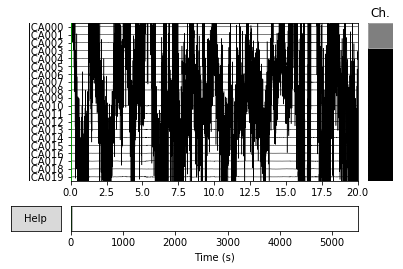

In [6]:
ica.plot_sources(raw)
pass

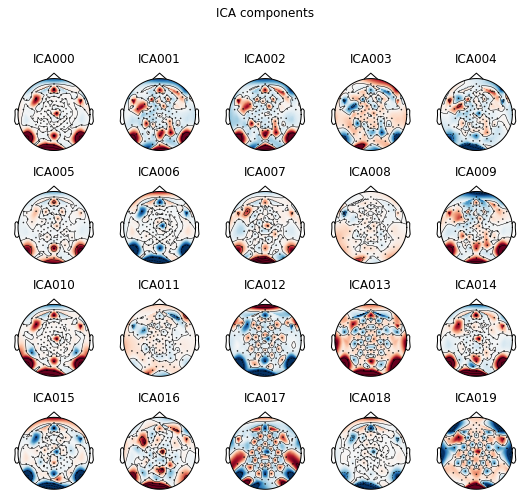

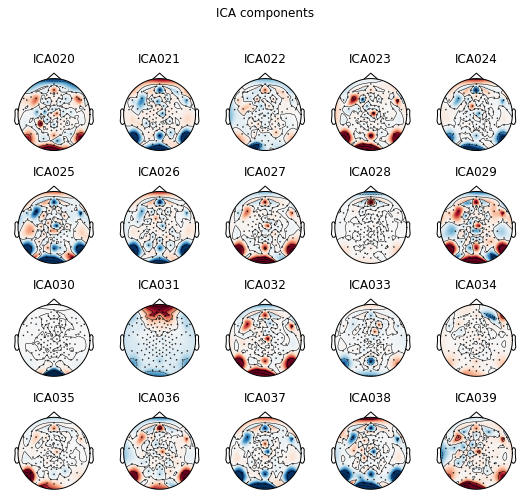

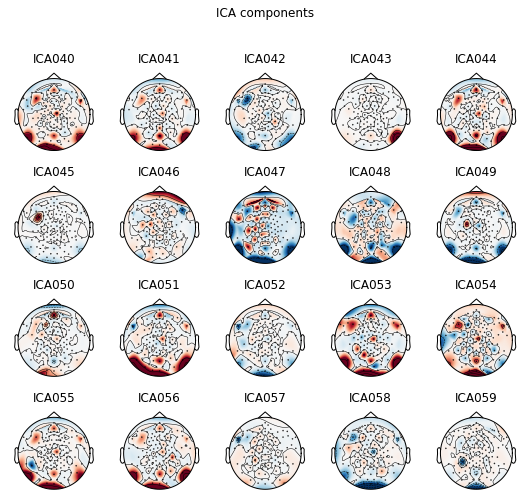

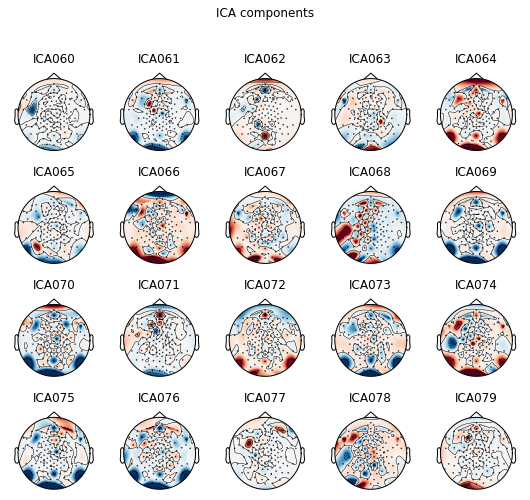

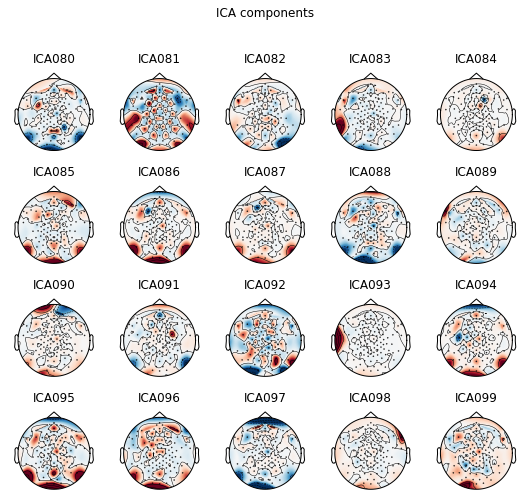

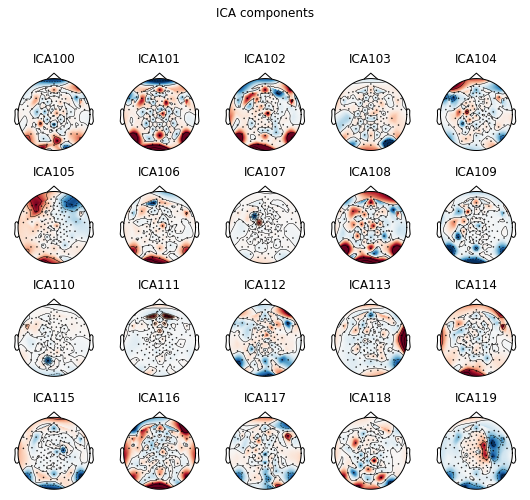

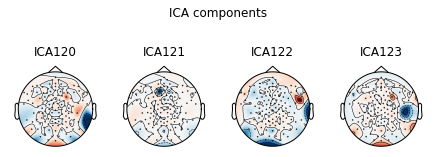

In [7]:
ica.plot_components()
pass

In [8]:
#####
# LCF
#####

iqr_thresh = 2
lcf_winsize = .25

# Clean artifacts from sources using LCF
cS = lcf(S, S, samp_rate, iqr_thresh=iqr_thresh, dilator_width=lcf_winsize, transition_width=lcf_winsize)

# Reconstruct data from cleaned sources
clean = raw.copy()
clean._data = reconstruct_signal(cS, ica)

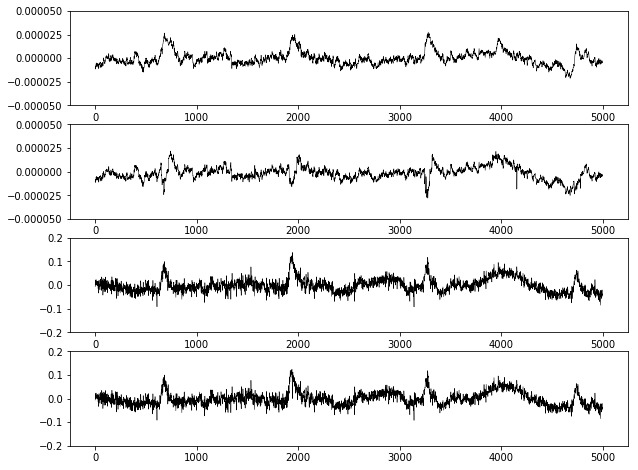

In [9]:
a=2000 * 500
b=2010 * 500
ch=5
co=5

plt.subplot(411)
plt.plot(raw._data[ch, a:b], linewidth=.5, color='k')
plt.ylim((-.00005, .00005))

plt.subplot(412)
plt.plot(clean._data[ch, a:b], linewidth=.5, color='k')
plt.ylim((-.00005, .00005))

plt.subplot(413)
plt.plot(S[co, a:b], linewidth=.5, color='k')
plt.ylim((-.2, .2))

plt.subplot(414)
plt.plot(cS[co, a:b], linewidth=.5, color='k')
plt.ylim((-.2, .2))

plt.gcf().set_size_inches(10, 8)
pass

# Loading cleaned data directly

In [10]:
from ptsa.data.TimeSeriesX import TimeSeriesX as TimeSeries

In [11]:
path = os.path.splitext(eegfile)[0] + '_clean.h5'
d = TimeSeries.from_hdf(path)